# Machine Translation
1- Import Dependanices

2- import dataset for training

3- Basic EDA and visualization

4- Data Cleaning

5- Tokenization and build vocabalury

6- Pad Sequence and Vectorization

7- Train model

8- Predictions


# Import Libraries

In [109]:
# basic libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import seaborn as sns
%matplotlib inline

# cleaning data
import re
import os
import nltk
nltk.download("stopwords")
nltk.download('punkt')

# save vocabulary in files
import pickle

# tokenization
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Model, Sequential
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional,LSTM, Dropout
from tensorflow.keras.layers import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.callbacks import ModelCheckpoint

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Import Dataset

In [110]:
df = pd.read_csv("fra.txt",delimiter="\t",names=["English","French"])
df.head()

,English,French
0,Go.,Va !
1,Run!,Cours !
2,Run!,Courez !
3,Wow!,Ça alors !
4,Fire!,Au feu !


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145437 entries, 0 to 145436
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   English  145437 non-null  object
 1   French   145437 non-null  object
dtypes: object(2)
memory usage: 2.2+ MB


In [112]:
df = df [:20000]

# Basic EDA and visualization

In [32]:
english_sentences = df['English']
french_sentences = df['French']
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

65086 English words.
5266 unique English words.
10 Most common words in the English dataset:
"I" "a" "you" "I'm" "is" "He" "You're" "You" "We" "the"

77730 French words.
9507 unique French words.
10 Most common words in the French dataset:
"Je" "?" "!" "pas" "Il" "suis" "de" "Nous" "est" "le"


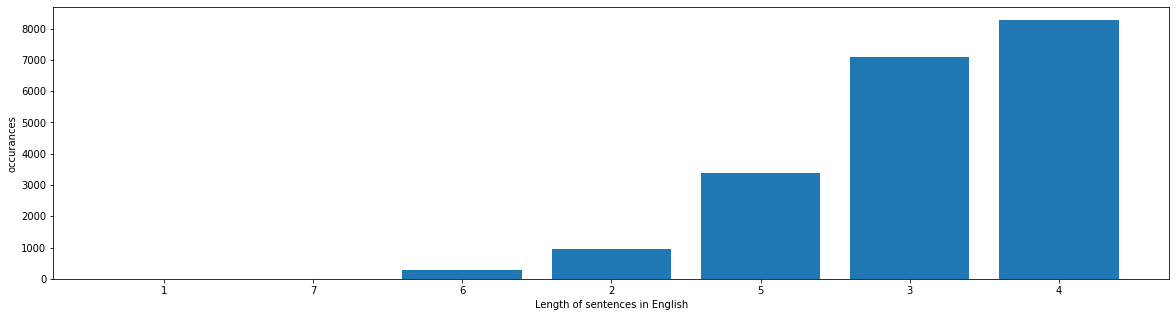

In [106]:
word_count = df['English'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))
index  = np.arange(len(word_dict))
values1 = word_dict.values()
plt.figure(figsize=(20,5))
plt.bar(index,values1)
plt.xlabel('Length of sentences in English')
plt.ylabel('occurances')
plt.xticks(index,word_dict.keys())
plt.show()

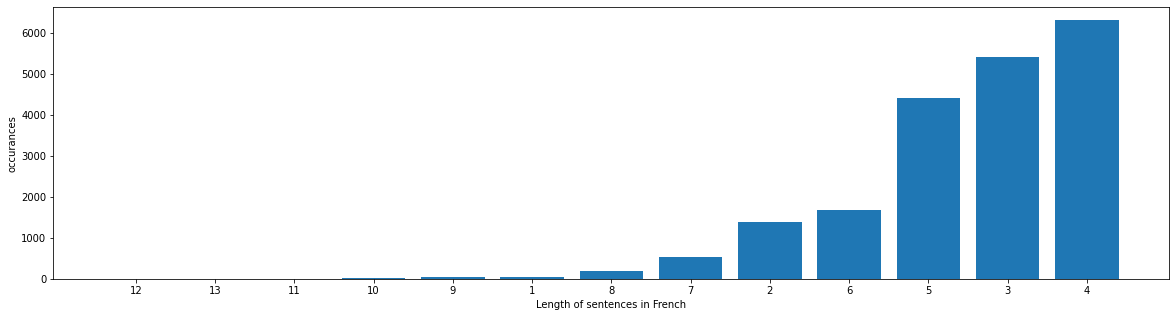

In [107]:
word_count = df['French'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))
index  = np.arange(len(word_dict))
values1 = word_dict.values()
plt.figure(figsize=(20,5))
plt.bar(index,values1)
plt.xlabel('Length of sentences in French')
plt.ylabel('occurances')
plt.xticks(index,word_dict.keys())
plt.show()

# Data Cleaning

In [33]:
# clean english column
def clean_english(text):
  text=text.lower() # lower case

  # remove any characters not a-z and ?!,'
  text=re.sub(u"[^a-z!?',]"," ",text)

  # word tokenization
  text=nltk.word_tokenize(text)

  # join text
  text=" ".join([i.strip() for i in text])

  return text

In [34]:
# clean frensh language
def clean_frensh(text):
  text=text.lower() # lower case

  # remove any characters not a-z and ?!,'
  # characters a-z and (éâàçêêëôîû) chars of french  which contain accent
  text=re.sub(u"[^a-zéâàçêêëôîû!?',]"," ",text)

  return text

In [35]:
df["English"]=df["English"].apply(lambda txt:clean_english(txt))

In [36]:
df["French"]=df["French"].apply(lambda txt:clean_frensh(txt))

# Tokenization

In [37]:
def tokenize(x):
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer

# Padding

In [38]:
def pad(x, length=None):
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen = 55, padding = 'post')

# Preprocess pipeline

In [39]:
def preprocess(x, y):
   
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

In [40]:
preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer = preprocess(english_sentences, french_sentences)

In [41]:
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

In [42]:
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Max English sentence length: 55
Max French sentence length: 55
English vocabulary size: 3378
French vocabulary size: 6665


 Convert the final prediction by our model into text form

In [43]:
def logits_to_text(logits, tokenizer):
    
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

# Model

In [44]:
def model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    
    learning_rate = 0.003
    
    # Build the layers
    model = Sequential()
    model.add(Embedding(french_vocab_size, 256, input_length=input_shape[1], input_shape=input_shape[1:]))
    model.add(Bidirectional(GRU(256, return_sequences=True)))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(english_vocab_size, activation='softmax'))) 

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

In [45]:
preproc_english_sentences.shape

(20000, 55)

In [46]:
tmp_x = pad(preproc_french_sentences, preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))

In [47]:
model = model(
    tmp_x.shape,
    preproc_english_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(french_tokenizer.word_index)+1)

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 55, 256)           1706496   
                                                                 
 bidirectional_1 (Bidirectio  (None, 55, 512)          789504    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 55, 1024)         525312    
 tributed)                                                       
                                                                 
 dropout_1 (Dropout)         (None, 55, 1024)          0         
                                                                 
 time_distributed_3 (TimeDis  (None, 55, 3379)         3463475   
 tributed)                                                       
                                                      

In [48]:
model.fit(tmp_x, preproc_english_sentences, batch_size=64, epochs=5, validation_split=0.2)

Epoch 1/5
250/250 [==============================] - 16s 51ms/step - loss: 0.5970 - accuracy: 0.9410 - val_loss: 0.3875 - val_accuracy: 0.9426
Epoch 2/5
250/250 [==============================] - 12s 49ms/step - loss: 0.2750 - accuracy: 0.9567 - val_loss: 0.3450 - val_accuracy: 0.9491
Epoch 3/5
250/250 [==============================] - 12s 49ms/step - loss: 0.2350 - accuracy: 0.9608 - val_loss: 0.3261 - val_accuracy: 0.9528
Epoch 4/5
250/250 [==============================] - 12s 49ms/step - loss: 0.2037 - accuracy: 0.9642 - val_loss: 0.3185 - val_accuracy: 0.9550
Epoch 5/5
250/250 [==============================] - 12s 48ms/step - loss: 0.1778 - accuracy: 0.9672 - val_loss: 0.3074 - val_accuracy: 0.9569


In [113]:
model.save('model.h5')

# Predictions

In [93]:
def translation(i):
  print ("French text:", french_sentences[i])
  print ("\nEnglish Translation:", english_sentences[i])
  print ("\nTranslation:", logits_to_text(model.predict(tmp_x[[i]])[0], english_tokenizer))

In [94]:
print(translation(680))

French text: laisse moi m'en aller !

English Translation: let me go !
1/1 [==============================] - 0s 20ms/step

Translation: let me go <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
None


In [95]:
print(translation(880))

French text: soyez sérieuses !

English Translation: be serious
1/1 [==============================] - 0s 21ms/step

Translation: be serious <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
None


In [104]:
print(translation(2700))

French text: êtes vous perdue ?

English Translation: are you lost ?
1/1 [==============================] - 0s 21ms/step

Translation: are you lost <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
None
